In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, \
                            auc, confusion_matrix, accuracy_score, \
                            classification_report

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

In [4]:
df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

In [5]:
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

In [6]:
df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

In [7]:
df_data_general[['number_of_day', 'INITIAL_AMOUNT', 'BET_TOTAL', 'TIME_ON_DEVICE_SEC', 'GAMES_PLAYED_TOTAL']].corr(method='spearman')

,number_of_day,INITIAL_AMOUNT,BET_TOTAL,TIME_ON_DEVICE_SEC,GAMES_PLAYED_TOTAL
number_of_day,1.00,0.01,0.01,0.02,0.01
INITIAL_AMOUNT,0.01,1.00,0.45,0.17,0.20
BET_TOTAL,0.01,0.45,1.00,0.80,0.85
TIME_ON_DEVICE_SEC,0.02,0.17,0.80,1.00,0.93
GAMES_PLAYED_TOTAL,0.01,0.20,0.85,0.93,1.00


In [8]:
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']

In [9]:
df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

In [10]:
df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

In [11]:
df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

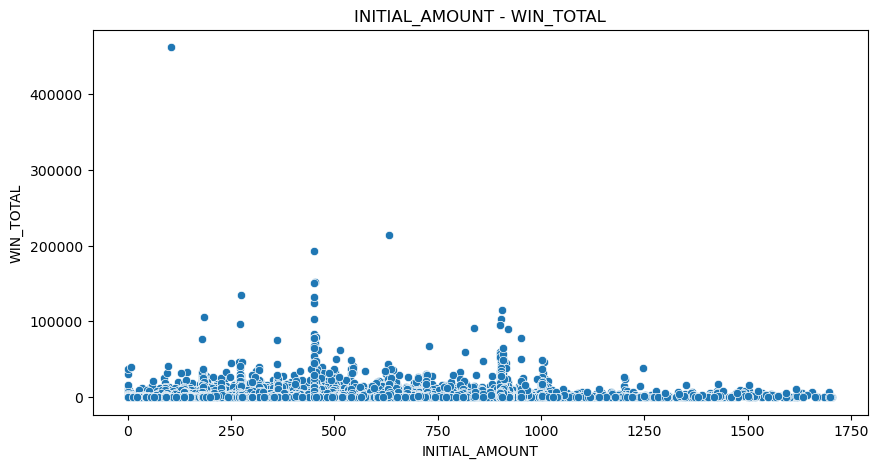

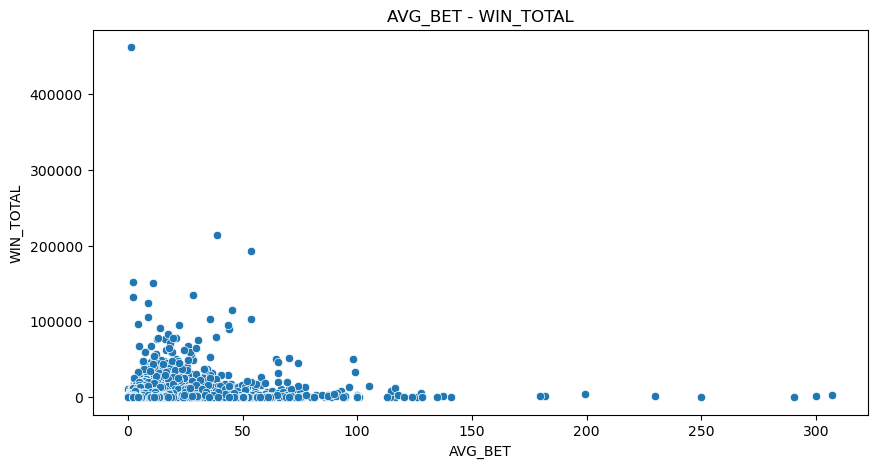

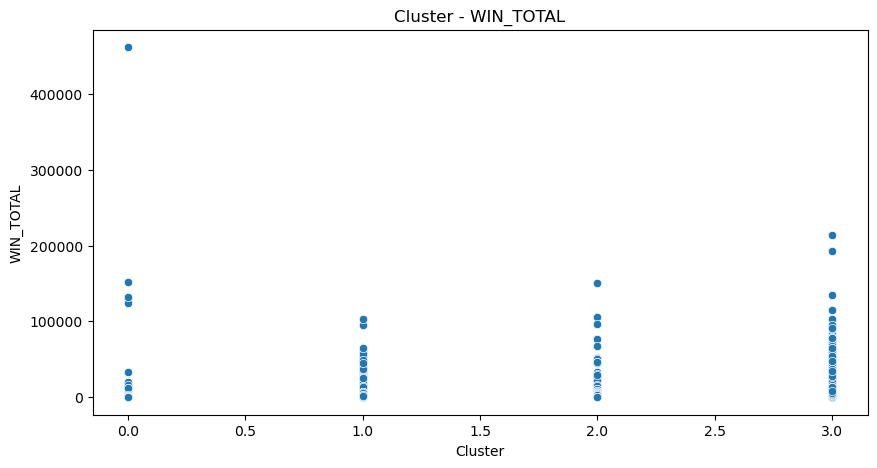

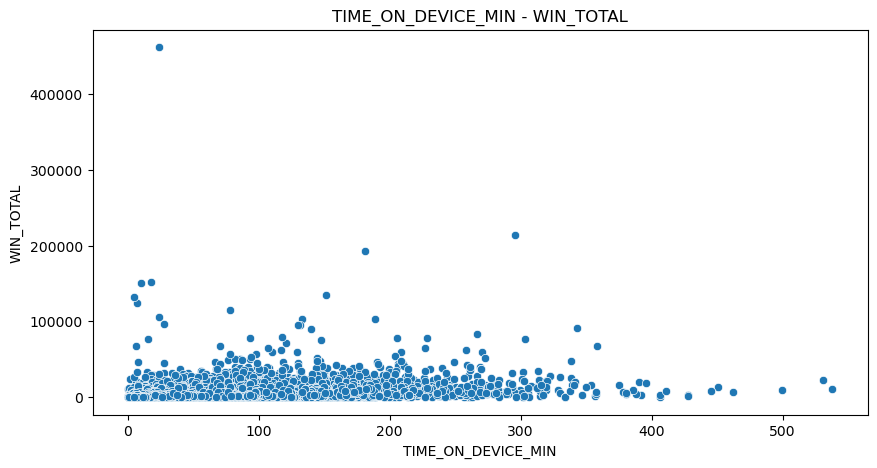

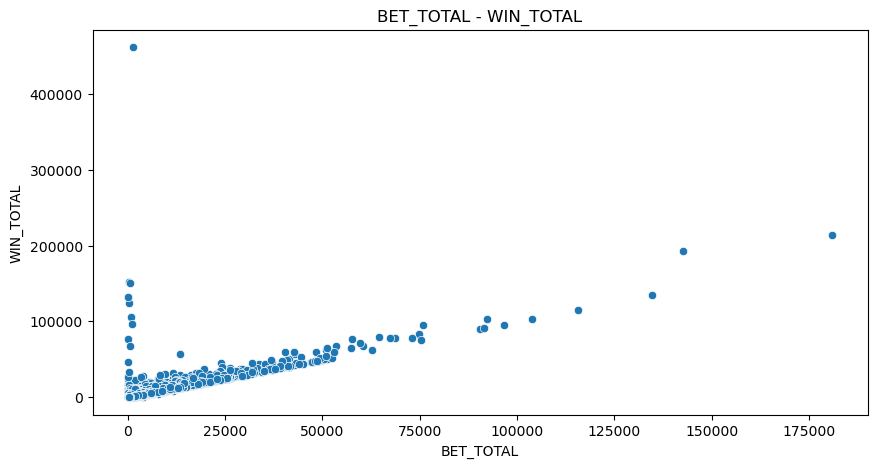

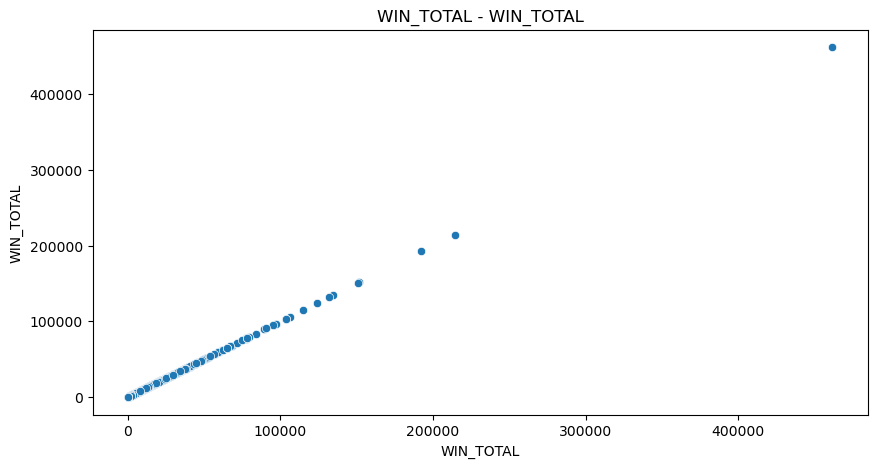

In [22]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'TIME_ON_DEVICE_MIN', 'BET_TOTAL', 'WIN_TOTAL']
df_selected_features = df_data_general[features]
df_selected_features = df_selected_features[df_selected_features['WIN_TOTAL'] > 0]

for feature in features:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=df_selected_features[feature], y=df_selected_features['WIN_TOTAL'])
    plt.title(f"{feature} - WIN_TOTAL")

In [15]:
df_data_general['WIN_TOTAL'].describe()

count     226731.00
mean         -20.61
std        33906.43
min     -9998594.00
25%           39.00
50%          176.75
75%          643.02
max       461502.00
Name: WIN_TOTAL, dtype: float64

In [23]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'TIME_ON_DEVICE_MIN', 'BET_TOTAL']

X = df_selected_features[features]
y = df_selected_features['WIN_TOTAL']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 222.07243476348685
R2: 0.8894417797294618


In [25]:
std_scaler = StandardScaler()
pipe = Pipeline([
        ('scaler', std_scaler),
        ('reg', RandomForestRegressor())
    ])

pipe.fit(X_train, y_train)

y_hat = pipe.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_hat))
print("R2:", r2_score(y_test, y_hat))

MAE: 221.7195951263236
R2: 0.8904143070041868


In [27]:
joblib.dump(pipe, '../../../models/win_total_pipeline_regressor_foliattiGeneral_v1.pkl')

['../../../models/win_total_pipeline_regressor_foliattiGeneral_v1.pkl']

<Axes: xlabel='WIN_TOTAL'>

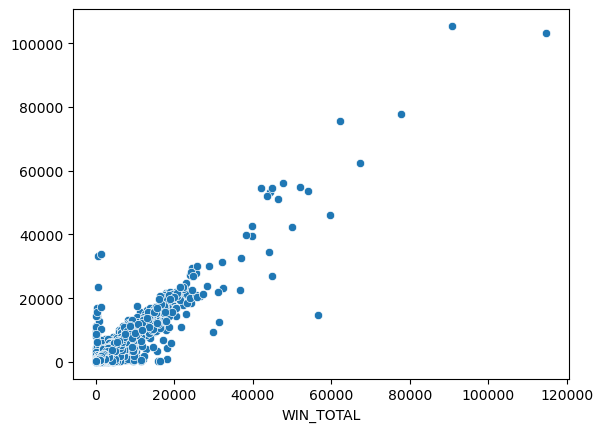

In [24]:
sns.scatterplot(x=y_test, y=y_pred)